# Task
Based on the program developed in the lecture (SparseRandomProjections), analyze 2 databases of your choice (but not exactly the same digits data as in the lecture) using random projections.
Study the accuracy (or a score of your choice that makes most sense for your data) as a function of the number of dimensions / features that survived the random projection.
Try to avoid a zick-zack curve below or around the baseline accuracy curve as your final result for both datasets. At least for one dataset the score is expected to be a smooth-ish curve as a function of the kept number of features. Provide a take-home statement and explain every step.
You will find that data that is embedded in Eukledian spaces (such as digits) may be more appropriate than data for which Eukledian distances are not an excellent distance measure.

In [1]:
## Random projections of high-dimensional data
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import datasets

import warnings
warnings.filterwarnings('ignore') # works

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Concept of Johnson-Lindenstrauss

The minimum number of components to guarantee the eps-embedding is given by:

$$
n\_components >= \frac{4 * log(n\_samples)}{(\frac{\epsilon^2}{2} - \frac{\epsilon^3}{3})}
$$

# Implementation of Random Projections

In [2]:
def random_projection (classifier, dataset, eps, metric, average):
    # Data Cleaning - Drop n/a
    data = dataset.dropna()
    
    # Split Data and Target
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    
    # Perfom train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    
    # Standardize the Data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    #######################################################################
    # Concept of Johnson-Lindenstrauss
    n = data.shape[0]
    # Print what the theory says for k, given an eps(ilon)
    print ("Professors Johnson and Lindenstrauss say: k >=", johnson_lindenstrauss_min_dim(n,eps=eps))
    
    #######################################################################
    # Classification
    # Initialize the model
    model = classifier

    # Train the Model
    model.fit(X_train, y_train)

    # Determine the baseline Score
    if metric == 'Accuracy': 
        baseline = metrics.accuracy_score(model.predict(X_test), y_test)
    else:
        baseline = metrics.f1_score(model.predict(X_test), y_test, average = average)

    # Create empty list to store the performance results
    results = []

    # determine the number of features in the dataset
    m = data.shape[1]
    
    # Create an evenly spaced list
    dims = np.int32(np.linspace(1, m, int(m/1)))
    
    # Loop over the projection sizes, k
    for dim in dims:
        # Create random projection
        sp = SparseRandomProjection(n_components = dim)
        X_train_transformed = sp.fit_transform(X_train)

        # Train classifier of your choice on the sparse random projection
        model = classifier
        model.fit(X_train_transformed, y_train)

        # Evaluate model and update accuracies
        X_test_transformed = sp.transform(X_test)
        if metric == 'Accuracy': 
            results.append(metrics.accuracy_score(model.predict(X_test_transformed), y_test))
        else:
            results.append(metrics.f1_score(model.predict(X_test_transformed), y_test, average = average))

    #######################################################################
    # Plotting
    # Create figure
    plt.figure()
    plt.title('Classifier: ' + str(classifier))
    plt.xlabel("# of dimensions k")
    plt.ylabel(metric)
    plt.xlim([1, m])
    plt.ylim([0, 1])
 
    # Plot baseline and random projection accuracies
    plt.plot(dims, [baseline] * len(results), color = "r")
    plt.plot(dims, results)

    plt.show()

## Download Dataset first

https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset

**Important:   
You need to download the dataset first and unpack the zip-file.
As such, we need to find a way how to use this for our submission for Jan.**

In [4]:
df_dataset = pd.read_excel('../data/Dry_Bean_Dataset.xlsx', header = 0)

df_dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [5]:
print('The class label frequency is:\n', df_dataset.iloc[:, -1].value_counts())

print('The shape of the dataset is:\n', df_dataset.shape)

The class label frequency is:
 DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64
The shape of the dataset is:
 (13611, 17)


Professors Johnson and Lindenstrauss say: k >= 8158


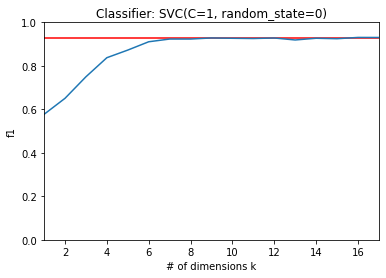

In [6]:
# Determine Classifier
classifier = SVC(kernel='rbf', C=1, random_state = 0)

# Determine eps
eps = 0.1

# Determine performance metric
metric = 'f1'

# Determine average for score evaluation
# for binary classification use 'binary', for mutliclass use 'weighted'
average = 'weighted'

# Call function
random_projection(classifier, df_dataset, eps, metric, average)